<a href="https://colab.research.google.com/github/jjbmsda/Blog/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# 데이터셋 로드 및 전처리
(x_train, _), _ = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255.

# 인코더 모델 구현
latent_dim = 8

encoder_inputs = tf.keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# 디코더 모델 구현
latent_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")


# VAE 모델 구현
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x):
        z_mean, z_log_var = self.encoder(x)
        return z_mean, z_log_var

    def reparameterize(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs, training=None, mask=None):
        x = inputs
        z_mean, z_log_var = self.encode(x)
        z = self.reparameterize(z_mean, z_log_var)
        reconstructed = self.decode(z)
        
        # Compute reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x, reconstructed)
        )
        
        # Compute KL divergence loss
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        
        # Combine both losses
        total_loss = reconstruction_loss + kl_loss
        
        self.add_loss(total_loss)
        return reconstructed

# 모델 컴파일 및 학습
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)


Epoch 1/30
469/469 [==============================] - 60s 124ms/step - loss: 0.2631
Epoch 2/30
469/469 [==============================] - 57s 122ms/step - loss: 0.2631
Epoch 3/30
469/469 [==============================] - 58s 124ms/step - loss: 0.2631
Epoch 4/30
469/469 [==============================] - 58s 123ms/step - loss: 0.2630
Epoch 5/30
469/469 [==============================] - 58s 124ms/step - loss: 0.2630
Epoch 6/30
469/469 [==============================] - 58s 124ms/step - loss: 0.2630
Epoch 7/30
469/469 [==============================] - 58s 124ms/step - loss: 0.2630
Epoch 8/30
469/469 [==============================] - 58s 124ms/step - loss: 0.2630
Epoch 9/30
469/469 [==============================] - 58s 124ms/step - loss: 0.2630
Epoch 10/30
469/469 [==============================] - 57s 121ms/step - loss: 0.2630
Epoch 11/30
469/469 [==============================] - 59s 126ms/step - loss: 0.2629
Epoch 12/30
469/469 [==============================] - 58s 123ms/step - lo

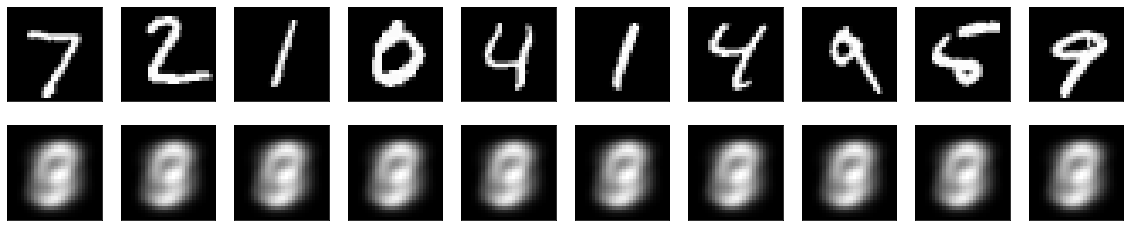

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터셋 로드 및 전처리
(x_train, _), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255.
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255.

# 모델 컴파일 및 학습
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
vae.fit(x_train, epochs=50, batch_size=128)

# 테스트 데이터를 사용하여 이미지 재구성
reconstructed_images = vae(x_test)

# 결과 시각화
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))

for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_images[i].numpy().reshape(28, 28), cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
